In [1]:
%load_ext autoreload
%autoreload

In [1]:
#from dipy.data import get_data
from nibabel import trackvis as tv
from dipy.segment.clustering import QuickBundles
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
import nibabel as nib
import networkx as nx

In [2]:
# brn_avg = nib.load("./HCP_S1200_1003_rfMRI_MSMAll_groupPCA_d4500ROW_zcorr.dconn.nii")
# print(type(brn_avg.header))
# ba_data = brn_avg.get_data()
# print(type(ba_data))
# brn_avg_em = nib.load("./HCP_S1200_1003_rfMRI_MSMAll_groupPCA_d4500_Eigenmaps.dtseries.nii")
# print(type(brn_avg_em))
# sub_100206_d50 = nib.load("./workbench/bin_windows64/100206.dconn.nii")
# sd50 = sub_100206_d50.get_data() 'paging file too small'; guess we have to work with cifti and not numpy...
# print(sd50.shape)
# print(type(sub_100206_d50))
# sub_100206_d50.shape

In [4]:
#sub_100206_d50 = nib.load("./workbench/bin_windows64/100206.dtseries.nii")
textract_100206_50 = pd.read_csv("100206.txt", sep=" ", header = None)#HCP_PTN1200/node_timeseries/3T_HCP1200_MSMAll_d50_ts2/
    #"./workbench/bin_windows64/100206_txt.txt", sep="\t", header=None)

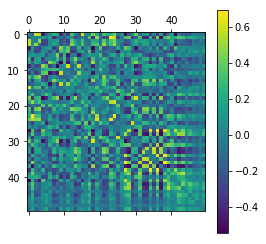

In [6]:
#sub_100206_d50.shape
textract_100206_50.shape
p100206_corr = textract_100206_50.corr()#np.fill_diagonal(textract_100206_50.corr(), 0)

# diagonal is perfectly correlated, cut that out

p100206_corr[p100206_corr == 1] = 0

cax = plt.matshow(p100206_corr)
plt.colorbar(cax)
plt.show()

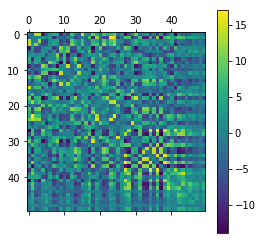

In [34]:
# we're discretizing the correlation
adj_mat = p100206_corr * 25

# remove bottom 10% of edges, (arbitrarily?)
#adj_mat[abs(adj_mat) < 2.5] = 0
# bucket them
adj_mat = np.floor(adj_mat)

cax = plt.matshow(adj_mat)
nm = mpc.Normalize(vmin=-15, vmax=15)
plt.colorbar(cax, norm=nm)
plt.show()




In [35]:
# can't use igraph bc/ windows.
#import igraph as ig; G_100206 = ig.Graph.Adjacency((abs(adj_mat > 0)).tolist())

G_100206 = nx.from_numpy_matrix(adj_mat.values, create_using=nx.MultiGraph())
len(G_100206.edges)
#G_100206.edges(data=True)
nx.diameter(G_100206) # #48 has weight under 10%
#comps = nx.connected_components(G_100206)
#first = 

2

In [8]:
from dipy.segment.clustering import QuickBundles as qbs

In [10]:
qb = qbs(threshold=10)
clusters = qb.cluster(sd50)

ValueError: Buffer has wrong number of dimensions (expected 2, got 1)

In [ ]:
nd = nib.load("C:\Users\Seth\Desktop\Internet Algorithms\NeuroNetworks\HCP_PTN1200\node_timeseries\3T_HCP1200_MSMAll_d50_ts2")

In [3]:
import dipy.reconst.dti as dti

In [5]:
white_matter = (ba_data == 1) | (ba_data == 2)

In [ ]:
from dipy.reconst.shm import CsaOdfModel
from dipy.data import default_sphere
from dipy.direction import peaks_from_model

csa_model = CsaOdfModel(gtab, sh_order=6)
csa_peaks = peaks_from_model(csa_model, data, default_sphere,
                             relative_peak_threshold=.8,
                             min_separation_angle=45,
                             mask=white_matter)